## Init 

In [ ]:
pip install gymnasium[mujoco]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install rover-arm==1.0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 11.5 MB/s eta 0:00:00


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1280, 720))
display.start()

In [ ]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode
from IPython.display import HTML
from base64 import b64encode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()
  
    def append(self, img):
        n_channels = img.shape[2]
        imgs = []
        for i in range(n_channels // 3):
            imgs.append(img[:,:,i * 3: (i + 1) * 3])
        self.images.append(np.hstack(imgs))

    def display(self, n = 100):
        if len(self.images) == 0:
            return
        images = self.images[:n]
        imageio.mimsave(self.buffer, images, format='gif')
        gif = Image(data=self.buffer.getvalue())
        display(gif)
        return gif
    def video_out(self, fname = "out", frate = 10, nframes = None):
        imageio.mimsave(f'{fname}.mp4', self.images[:nframes], 'mp4', fps=frate)
        mp4 = open(f'{fname}.mp4','rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        html = HTML("""
        <video width=400 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)
        display(html)
        return html

    def __len__(self):
      return len(self.images)

In [ ]:
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def t(x):
    return torch.from_numpy(np.array(x)).float().to(device)
def n(x):
    return x.cpu().detach().numpy()

cuda


In [ ]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import cv2
import random
from vit_pytorch.vit_3d import ViT
import gymnasium as gym
import gc

In [ ]:
# np.interp([0.46088192,  0.43671983,  0.2762557], [-1, 1], [0, n_actions - 1])
# scale = 1
# discretize_actions([0.46088192,  0.43671983,  0.2262557], n_actions, scale)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def discretize_actions(actions, actions_per_dim, scale):
    actions = np.array(actions) / scale
    actions = np.interp(actions, [-1, 1], [0, actions_per_dim - 1])
    return np.array(actions, dtype = np.int64)

def continuize_actions(actions, actions_per_dim, scale):
    actions = np.interp(actions, [0, actions_per_dim - 1], [-1, 1])
    actions *= scale
    return np.array(actions)
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")

## Models

### DQN 

#### Standard 

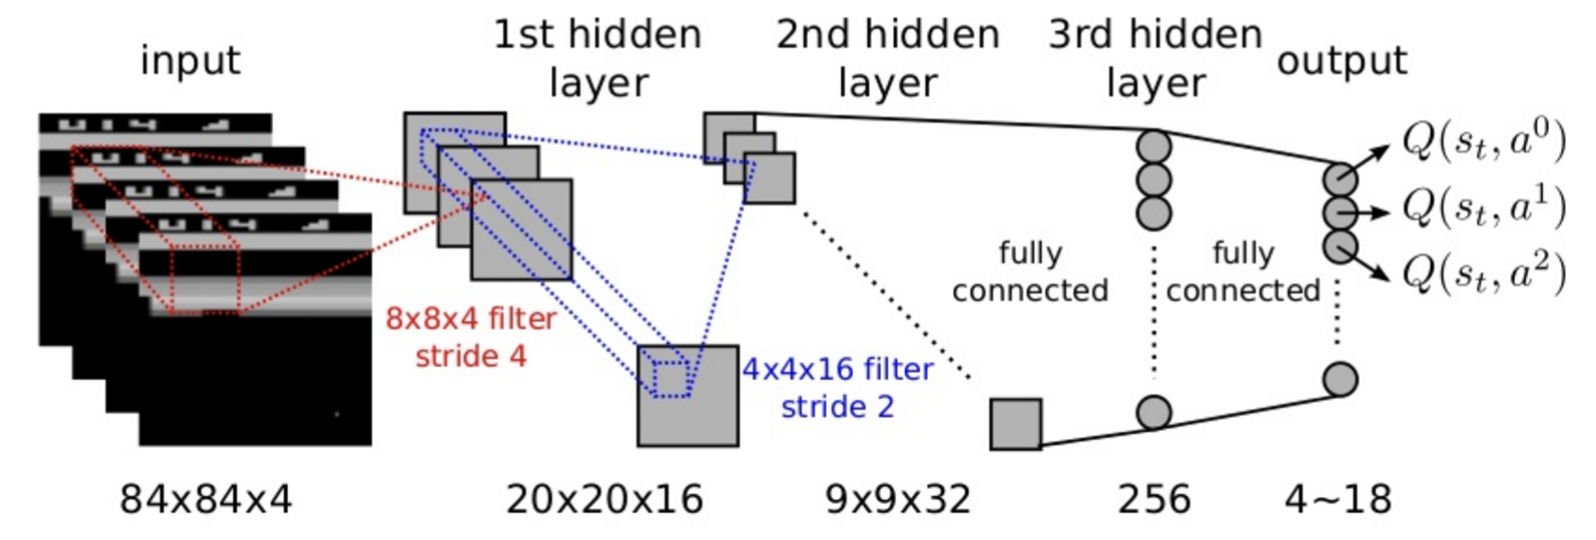

In [ ]:
# Model takes input dimension 4 which is state shape
# The output is 2, which is the no. of actions 
# Therefore, Q(S) is modeled to return the Q value for each action and we pick the action with max Q value.
class Model_DQN_1(nn.Module):
    def __init__(self, input_channels, N_FRAMES, n_actions, actions_per_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(N_FRAMES, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        self.fc1 = nn.Linear(288 * 9, 256)
        self.fc2 = nn.Linear(256, n_actions * actions_per_dim)

        

    def forward(self, state_t):
        x = state_t.squeeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 288 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, self.n_actions , self.actions_per_dim)
        x = F.softmax(x, dim = -1)
        return x

    
    def get_action(self, state):
        state = np.array(state)
        state_t = torch.as_tensor(state, dtype = torch.float32).to(device)
        # Model expects the input to be in the dimension (1, input_dim), 
        # so we unsqueeze to add a dimension.
        state_t = state_t.unsqueeze(0)
        # Model's forward method will be called using self() method. 
        actions_t = self(state_t)
        # Max action is returned. 
        max_action = n(torch.argmax(actions_t, dim = -1))
        return max_action

In [ ]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
n_frames = 4
input_channels = 1
model = Model_DQN_1(input_channels, n_frames, n_actions, actions_per_dim).to(device)

state_t = t(np.ones((2, 1,4, 84, 84)))

model(state_t).shape, model.get_action(n(state_t[0]))

(torch.Size([2, 7, 20]), array([[ 0,  5, 11, 12, 16,  8, 18]]))

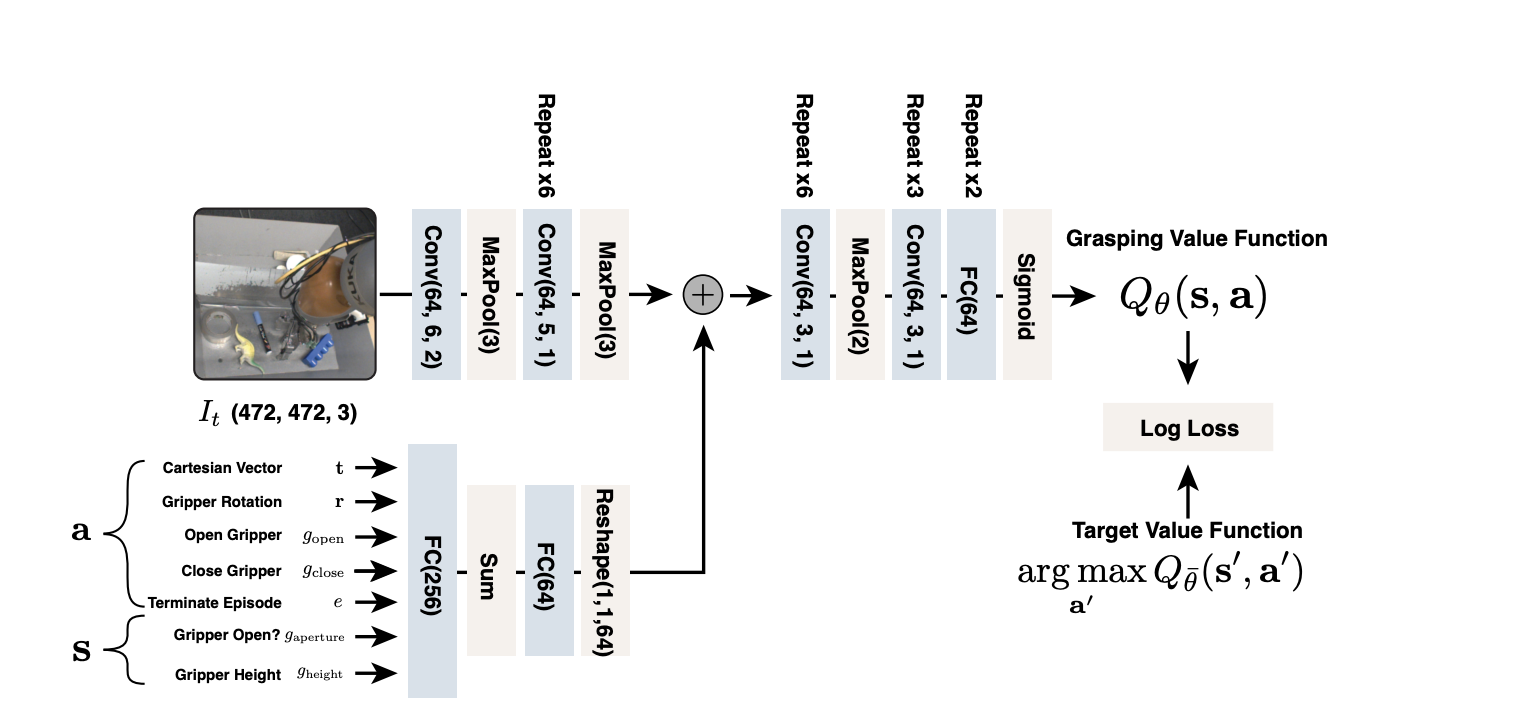

#### Standard - Observation Info Added


In [ ]:
class Model_DQN_2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, actions_per_dim, obs_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 2)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 2)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(2304, 64)
        self.fc4 = nn.Linear(64, n_actions * actions_per_dim)

    def forward(self, state_t, obs_t):
        x = state_t.squeeze(2)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64,1,1)
        
        x = x + o
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        
        x = x.view(-1 , 2304)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(-1, self.n_actions , self.actions_per_dim)
        x = F.softmax(x, dim = -1)
        return x

    
    def get_action(self, state, obs):
        state = np.array(state)
        state_t = torch.as_tensor(state, dtype = torch.float32).to(device)

        obs_t = torch.as_tensor(obs, dtype = torch.float32).to(device)

        # Model expects the input to be in the dimension (1, input_dim), 
        # so we unsqueeze to add a dimension.
        state_t = state_t.unsqueeze(0)
        obs_t = obs_t.unsqueeze(0)
        # Model's forward method will be called using self() method. 
        actions_t = self(state_t, obs_t)
        
        # Max action is returned. 
        max_action = n(torch.argmax(actions_t, dim = -1))
        return max_action


In [ ]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
input_channels = 6

model = Model_DQN_2(input_channels, 1, n_actions, actions_per_dim, obs_dim).to(device)

state_t = t(np.ones((2,6,1,224,224)))
obs_t = t(torch.ones(2, obs_dim))

model(state_t, obs_t).shape, model.get_action(n(state_t[0]), obs_t[0])

(torch.Size([2, 7, 20]), array([[ 1,  6,  5, 12, 15,  7,  2]]))

#### Standard - Observation Info Concatenated

In [ ]:
class Model_DQN_3(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, actions_per_dim, obs_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 1)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(2304, 64)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions * actions_per_dim)

    def forward(self, state_t, obs_t):
        x = state_t.squeeze(2)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        

        x = x.view(-1 , 2304)
        x = F.relu(self.fc3(x))

        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64)
        # x = x + o

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = x.view(-1, self.n_actions , self.actions_per_dim)
        x = F.softmax(x, dim = -1)
        return x

    
    def get_action(self, state, obs):
        state = np.array(state)
        state_t = torch.as_tensor(state, dtype = torch.float32).to(device)

        obs_t = torch.as_tensor(obs, dtype = torch.float32).to(device)

        # Model expects the input to be in the dimension (1, input_dim), 
        # so we unsqueeze to add a dimension.
        state_t = state_t.unsqueeze(0)
        obs_t = obs_t.unsqueeze(0)
        # Model's forward method will be called using self() method. 
        actions_t = self(state_t, obs_t)
        
        # Max action is returned. 
        max_action = n(torch.argmax(actions_t, dim = -1))
        return max_action

In [ ]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.shape[0]
input_channels = 3
model = Model_DQN_3(input_channels, 1, n_actions, actions_per_dim, obs_dim).to(device)

state_t = t(np.ones((2, 3 , 1, 224, 224)))
obs_t = t(torch.ones(2, obs_dim))

model(state_t, obs_t).shape, model.get_action(n(state_t[0]), obs_t[0])

(torch.Size([2, 7, 20]), array([[ 5, 11, 15, 18,  6, 13, 17]]))

#### 3D Vision Transformers

In [ ]:
class Model_DQN_ViT_1(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, actions_per_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, n_actions * actions_per_dim)

    def forward(self, state_t):
        x = self.vit(state_t)
        x = F.relu(self.fc1(x))
        x = x.view(-1, self.n_actions , self.actions_per_dim)
        x = F.softmax(x, dim = -1)
        return x

    
    def get_action(self, state):
        state = np.array(state)
        state_t = torch.as_tensor(state, dtype = torch.float32).to(device)
        state_t = state_t.unsqueeze(0)
        actions_t = self(state_t)
        max_action = n(torch.argmax(actions_t, dim = -1))
        return max_action
        

In [ ]:
N_FRAMES = 16
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]

model = Model_DQN_ViT_1(input_channels, N_FRAMES, n_actions, actions_per_dim).to(device)

state_t = t(np.ones((2,3, 16, 64, 64)))

model(state_t).shape, model.get_action(n(state_t[0]))

(torch.Size([2, 7, 20]), array([[18, 11, 14,  0, 14,  7, 15]]))

#### 3D Vision Transformers - Observation Info **Concatenated**

In [ ]:
class Model_DQN_ViT_2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, actions_per_dim, obs_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, 64)

        self.fc2 = nn.Linear(obs_dim, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions * actions_per_dim)

        

    def forward(self, state_t, obs_t):
        x = self.vit(state_t)
        x = F.relu(self.fc1(x))

        o = F.relu(self.fc2(obs_t))
        o = F.relu(self.fc3(o))
        o = o.view(-1,64)

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = x.view(-1, self.n_actions , self.actions_per_dim)
        x = F.softmax(x, dim = -1)
        return x

    
    def get_action(self, state, obs):
        state = np.array(state)
        state_t = torch.as_tensor(state, dtype = torch.float32).to(device)

        obs_t = torch.as_tensor(obs, dtype = torch.float32).to(device)

        # Model expects the input to be in the dimension (1, input_dim), 
        # so we unsqueeze to add a dimension.
        state_t = state_t.unsqueeze(0)
        obs_t = obs_t.unsqueeze(0)
        # Model's forward method will be called using self() method. 
        actions_t = self(state_t, obs_t)
        
        # Max action is returned. 
        max_action = n(torch.argmax(actions_t, dim = -1))
        return max_action
        

In [ ]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
n_frames = 10
input_channels = 6
model = Model_DQN_ViT_2(input_channels, n_frames, n_actions, actions_per_dim, obs_dim).to(device)

state_t = t(np.ones((2,6, 10, 128, 128)))
obs_t = t(torch.ones(2, obs_dim))

model(state_t, obs_t).shape, model.get_action(n(state_t[0]), obs_t[0])

(torch.Size([2, 7, 20]), array([[ 9, 12, 13,  8, 16,  3, 15]]))

## Environments

In [ ]:
def run_sample(env, max_steps = 100, fname = "out", frate = 10, nframes = 100, is_rover_env = False):
    g = GIFMaker() # visualization
    _, info = env.reset()
    observation = env.render() # use visual input this time!
    for i in range(max_steps):
        action = env.action_space.sample()
        _, reward, terminated, truncated, info = env.step(action)
        if is_rover_env:
            observation = env.render(480, 480)
        else:
            observation = env.render()
        g.append(observation) # save one frame for GIF
        if terminated or truncated:
            _, info = env.reset()
            break
    g.video_out(fname , frate , nframes) # show GIF animation
    env.close()
    return g

In [ ]:
# env

## Training

In [ ]:
class Trainer():
    def __init__(self, model, env, n_frames, actions_per_dim, img_shape, is_rover_env, device,
                 BATCH_SIZE = 3, REPLAY_BUFFER_SIZE = 10):
        self.n_frames = n_frames
        self.env = env
        self.model = model
        self.n_actions = env.action_space.shape[0]
        self.obs_dim = env.observation_space.shape[0]
        self.actions_per_dim = actions_per_dim
        self.img_shape = img_shape
        self.device = device
        self.is_rover_env = is_rover_env
        self.BATCH_SIZE = BATCH_SIZE
        self.models_obs_req = {
            Model_DQN_1 : 0,
            Model_DQN_2: 1,
            Model_DQN_3: 1,
            Model_DQN_ViT_1: 0,
            Model_DQN_ViT_2: 1
        }
        
        env.reset()
        self.input_channels = env.render().shape[2]
        self.episode_rewards = []
        self.Q_net, self.T_net, self.optimizer = self.initialize_models()
        self.replay_buffer = self.initialize_replay_buffer(REPLAY_BUFFER_SIZE)

        
    def initialize_models(self):
        n_frames = self.n_frames
        if self.models_obs_req[self.model]:
            Q_net = self.model(self.input_channels, self.n_frames, self.n_actions, self.actions_per_dim, self.obs_dim).to(self.device)
            T_net = self.model(self.input_channels, self.n_frames, self.n_actions, self.actions_per_dim, self.obs_dim).to(self.device)
        else:
            Q_net = self.model(self.input_channels, self.n_frames, self.n_actions, self.actions_per_dim).to(self.device)
            T_net = self.model(self.input_channels, self.n_frames, self.n_actions, self.actions_per_dim).to(self.device)
        T_net.load_state_dict(Q_net.state_dict())
        optimizer = torch.optim.Adam(Q_net.parameters(), lr= 5e-4 )
        return Q_net, T_net, optimizer


    def initialize_replay_buffer(self, REPLAY_BUFFER_SIZE):

        img_shape = self.img_shape

        replay_buffer = deque(maxlen = REPLAY_BUFFER_SIZE)
        state = deque(maxlen = self.n_frames)
        for i in range(self.n_frames): 
            state.append(np.zeros(img_shape, dtype = np.uint8))
        
        ep = 0
        obs, info = env.reset()
        for step in range(REPLAY_BUFFER_SIZE):
            action = env.action_space.sample()
            prev_obs = obs.copy()
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if self.is_rover_env:
                render_shape = [img_shape[0],img_shape[1]]
            else:
                render_shape = []
            img = env.render(*render_shape)     
            img = cv2.resize(img, (img_shape[0],img_shape[1]))
            if img_shape[2] == 1:
                img = cv2.cvtColor(img[:,:,:3], cv2.COLOR_RGB2GRAY)
                img = np.expand_dims(img, axis=-1)
            prev_state = state.copy()
            state.append(img)
            # assert np.sum(prev_state[-1] -  state[-1]) != 0
            # assert np.sum(prev_obs -  obs) != 0
            action = discretize_actions(action, self.actions_per_dim, 1)

            
            replay_buffer.append((np.moveaxis(prev_state, -1, 0), prev_obs, action, reward, terminated, np.moveaxis(state, -1, 0), obs))
            
            if done:
                ep += 1
                _, info = env.reset()
                for i in range(N_FRAMES):
                    state.append(np.zeros(img_shape, dtype = np.uint8))
        return replay_buffer

        
    def train(self, EPISODES = 1, GAMMA = 0.95, ALPHA = 0.01, MAX_STEPS_PER_EPISODE = 100, display = False):
        EPSILON_START=1
        EPSILON_END=0.02
        EPSILON_DECAY_EPISODES = (EPISODES) // 2

        REPLAY_BUFFER_SIZE = 10000  
        N_FRAMES = self.n_frames
        actions_per_dim = self.actions_per_dim
        REWARD_BUFFER_SIZE = 1
        BATCH_SIZE = self.BATCH_SIZE

        TARGET_UPDATE_FREQUENCY = 10
        RECORDED_EPISODES = 10
        
        # Environment Constants
        env = self.env

        
        Q_net, T_net, optimizer = self.Q_net, self.T_net, self.optimizer        
        replay_buffer = self.replay_buffer
        
        self.g = GIFMaker() # visualization
        obs, info = env.reset()
        episode_reward = 0

        state = deque(maxlen = N_FRAMES)
        img_shape = self.img_shape
        models_obs_req = self.models_obs_req

        for ep in range(EPISODES):
            # Epsilon Decay over EPSILON_DECAY_EPISODES no. of episodes
            epsilon = np.interp(ep, [0, EPSILON_DECAY_EPISODES], [EPSILON_START, EPSILON_END])
            done = False
            rewards = []
            for i in range(N_FRAMES): 
                state.append(np.zeros(img_shape, dtype = np.uint8))
            step = 0
            while not done:
                step += 1
                state_n = np.moveaxis(np.array(state), -1, 0)
                if random.random() > epsilon:
                    if models_obs_req[self.model]:
                        action = continuize_actions( Q_net.get_action(state_n, obs) , actions_per_dim, 1).squeeze(0)
                    else:
                        action = continuize_actions( Q_net.get_action(state_n) , actions_per_dim, 1).squeeze(0)
                else:
                    action = env.action_space.sample()
                
                prev_obs = obs.copy()
                obs, reward, terminated, truncated, info = env.step(action)
            
                if self.is_rover_env:
                    render_shape = [img_shape[0],img_shape[1]]
                else:
                    render_shape = []
                img_org = env.render(*render_shape)
                img = cv2.resize(img_org, (img_shape[0],img_shape[1]))
                
                if img_shape[2] == 1:
                    img = cv2.cvtColor(img[:,:,:3], cv2.COLOR_RGB2GRAY)
                    img = np.expand_dims(img, axis=-1)
                prev_state = state.copy()
                state.append(img)

                episode_reward += reward
                done = terminated or truncated
                if step > MAX_STEPS_PER_EPISODE :
                    done = 1
                if step % 10 ==0 :
                    print(f"{step = }, {episode_reward = }")
                
                action = discretize_actions(action, actions_per_dim, 1)

                prev_state_n = np.moveaxis(np.array(prev_state), -1, 0)
                state_n = np.moveaxis(np.array(state), -1, 0)
                replay_buffer.append((prev_state_n, prev_obs, action, reward, terminated, state_n, obs))
                
                sampled_transitions = random.sample(replay_buffer,BATCH_SIZE)

                states, obses, actions, rewards, dones, new_states, new_obses = [[t[i] for t in sampled_transitions] for i in range(7)]
                
                
                states_t = torch.as_tensor(np.array(states), dtype = torch.float32 ).to(device)
                rewards_t = torch.as_tensor(np.array(rewards), dtype = torch.float32 ).unsqueeze(-1).to(device)
                new_states_t = torch.as_tensor(np.array(new_states), dtype = torch.float32 ).to(device)
                actions_t =  torch.as_tensor(np.array(actions), dtype = torch.int64 ).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(np.array(dones), dtype = torch.int64 ).unsqueeze(-1).to(device)
                
                # print(states_t.shape, new_states_t.shape)
                if models_obs_req[self.model]:
                    obses_t = torch.as_tensor(np.array(obses), dtype = torch.float32 ).to(device)
                    new_obses_t = torch.as_tensor(np.array(new_obses), dtype = torch.float32 ).to(device)
                    # print(obses_t.shape, new_obses_t.shape)

                if models_obs_req[self.model]:
                    y_q_values = T_net(new_states_t, new_obses_t)
                else:
                    y_q_values = T_net(new_states_t)
                
                y = y_q_values.max(dim = 2, keepdim= True)[0].squeeze(-1)
                
                target_q_values = rewards_t + GAMMA * (1 - dones_t) * y
                
                if models_obs_req[self.model]:
                    q_values = Q_net(states_t, obses_t)
                else:
                    q_values = Q_net(states_t)
                

                actions_t = actions_t.view(BATCH_SIZE,-1,1)
                action_q_values = torch.gather(input=q_values, dim = 2, index = actions_t).squeeze(-1)
                loss = nn.functional.smooth_l1_loss(action_q_values, target_q_values)

                #Gradient Descent 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Loading Target network with Q network 
                if ep % TARGET_UPDATE_FREQUENCY == 0:
                    T_net.load_state_dict(Q_net.state_dict())

                # Saving the last RECORDED_EPISODES no. of episodes of the Run
                if EPISODES - ep < RECORDED_EPISODES:
                    self.g.append(img_org) # save one frame
                
            observation, info = env.reset()
            self.episode_rewards.append(episode_reward)
            episode_reward = 0

            if ep % REWARD_BUFFER_SIZE == 0:
                avg_episode_reward = np.mean(self.episode_rewards[-REWARD_BUFFER_SIZE:])
                print(f"Episode {ep}, reward {avg_episode_reward}")
                if avg_episode_reward > 450:
                    break

        self.g.display() # show GIF animation
        return (self.episode_rewards, self.g)
    def close(self):
        self.env.close()
                

                

In [ ]:
# trainer = Trainer(Model_DQN_1, env, 4, 20, (84,84,1), 0, device)
# trainer = Trainer(Model_DQN_2, env, 1, 20, (472,472,3), 0, device)
# trainer = Trainer(Model_DQN_3, env, 1, 20, (472,472,3), 0, device)
# trainer = Trainer(Model_DQN_ViT_1, env, 16, 20, (128,128,3), 0, device)
# trainer = Trainer(Model_DQN_ViT_2, env, 16, 20, (128,128,3), 0, device)

In [ ]:
def gc_collect():
    try: 
        del trainer
    except: pass
    gc.collect()

224 244


### Half Cheetah

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
g = run_sample(env)
dqn_rewards_half_cheetah = {}
EPISODES, STEPS = 1, 20

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_1, env, 4, 20, (84,84,1), 0, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)
dqn_rewards_half_cheetah[Model_DQN_1] = episode_rewards

np.save("dqn_rewards_half_cheetah[Model_DQN_1]).npy", dqn_rewards_half_cheetah[Model_DQN_1])

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_2, env, 1, 20, (472,472,3), 0, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_half_cheetah[Model_DQN_2] = episode_rewards
np.save("dqn_rewards_half_cheetah[Model_DQN_2]).npy", dqn_rewards_half_cheetah[Model_DQN_2])

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_3, env, 1, 20, (472,472,3), 0, device)

episode_rewards, g = trainer.train(EPISODES)
dqn_rewards_half_cheetah[Model_DQN_3] = episode_rewards

np.save("dqn_rewards_half_cheetah[Model_DQN_3]).npy", dqn_rewards_half_cheetah[Model_DQN_3])

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_ViT_1, env, 8, 20, (128,128,3), 0, device)

episode_rewards, g = trainer.train(EPISODES)
dqn_rewards_half_cheetah[Model_DQN_ViT_1] = episode_rewards

np.save("dqn_rewards_half_cheetah[Model_DQN_ViT_1]).npy", dqn_rewards_half_cheetah[Model_DQN_ViT_1])

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_ViT_2, env, 8, 20, (128,128,3), 0, device)

episode_rewards, g = trainer.train(EPISODES)
dqn_rewards_half_cheetah[Model_DQN_ViT_2] = episode_rewards

np.save("dqn_rewards_half_cheetah[Model_DQN_ViT_2]).npy", dqn_rewards_half_cheetah[Model_DQN_ViT_2])

### Pusher

In [ ]:
import gymnasium as gym
env = gym.make("Pusher-v4", render_mode="rgb_array")
run_sample(env)

dqn_rewards_pusher = {}

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_1, env, 4, 20, (84,84,1), 0, device)

episode_rewards, g = trainer.train(1)
dqn_rewards_pusher[Model_DQN_1] = episode_rewards
np.save("dqn_rewards_pusher[Model_DQN_1]).npy", episode_rewards)

### Rover-Arm - Task1 

In [ ]:
import rover_arm
env = gym.make('rover-arm-pick-v0', render_mode = 'rgb_array')
# g = run_sample(env, is_rover_env=True)
EPISODES, STEPS = 2, 15

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gymnasium/envs/registration.py:491: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
dqn_rewards_rover_arm_1 = {}

/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:197: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:347: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is Non

step = 10, episode_reward = -0.0008667916712548129
Episode 0, reward 2.7816413430628632e-05
step = 10, episode_reward = -0.00024550069623247017
Episode 1, reward -0.00024550069623247017


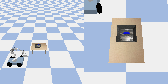

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_1, env, 4, 20, (84,84,1), 1, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_rover_arm_1[Model_DQN_1] = episode_rewards
np.save("dqn_rewards_rover_arm_1[Model_DQN_1]).npy", episode_rewards)

step = 10, episode_reward = -0.0004330397390407638
Episode 0, reward -0.001549813043928719
step = 10, episode_reward = -0.001344178294551837
Episode 1, reward -0.00246478828690449


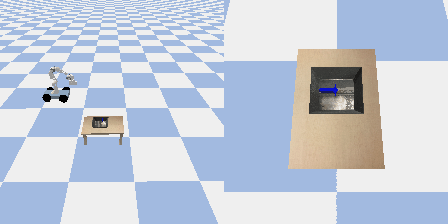

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_2, env, 1, 20, (224,224,6), 1, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_rover_arm_1[Model_DQN_2] = episode_rewards
np.save("dqn_rewards_rover_arm_1[Model_DQN_2]).npy", episode_rewards)

step = 10, episode_reward = 0.001657259168683334
Episode 0, reward 0.0028391908063187866
step = 10, episode_reward = 0.0014672924369791922
Episode 1, reward 0.00041011277780030595


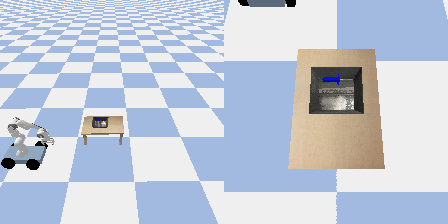

In [ ]:
trainer = Trainer(Model_DQN_3, env, 1, 20, (224,224,6), 1, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_rover_arm_1[Model_DQN_3] = episode_rewards
np.save("dqn_rewards_rover_arm_1[Model_DQN_3]).npy", episode_rewards)

step = 10, episode_reward = 0.001009030589511445
Episode 0, reward 0.0003981750278010595
step = 10, episode_reward = 0.003413370995882947
Episode 1, reward 0.006631560687562377


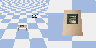

In [ ]:
trainer = Trainer(Model_DQN_ViT_1, env, 16, 20, (128,128,6), 0, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_rover_arm_1[Model_DQN_ViT_1] = episode_rewards
np.save("dqn_rewards_rover_arm_1[Model_DQN_ViT_1]).npy", episode_rewards)

step = 10, episode_reward = -0.0002981016279995308
Episode 0, reward 0.0002972531413368839
step = 10, episode_reward = -0.0008833288289758378
Episode 1, reward -0.0024722120649128708


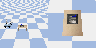

In [ ]:
gc_collect()

trainer = Trainer(Model_DQN_ViT_2, env, 8, 20, (128,128,6), 0, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

dqn_rewards_rover_arm_1[Model_DQN_ViT_2] = episode_rewards
np.save("dqn_rewards_rover_arm_1[Model_DQN_ViT_2]).npy", episode_rewards)

### Rover-Arm - Task2

In [ ]:
# next(Q_net.parameters()).is_cuda